# Getting started with tket

This demo notebook gives an overview of currently implemented tket2 features.

Be aware that the library is still in development and some features may not be
fully implemented or may change in the future.



In [2]:
from tket.circuit import Tk2Circuit
import math

Let's configure pretty printing for the circuits, using the mermaid renderer. This will render the circuit graphs in `jupyter-lab`, but it is not currently supported when viewing the library in vscode.

In [3]:
from utils import setup_jupyter_rendering # type: ignore
# NOTE: This requires having `dot` (aka graphviz) installed on your system.
setup_jupyter_rendering()

# Defining circuits

There are multiple ways for defining circuits in tket2.
The library provides two limited builders, and it supports importing circuits from `guppy` and `pytket`.

### Using the commands-based builder

The simplest way is to use the commands-based builder interface `CircBuild`.
It supports constructing circuits by listing a series of commands applied to specific qubits.

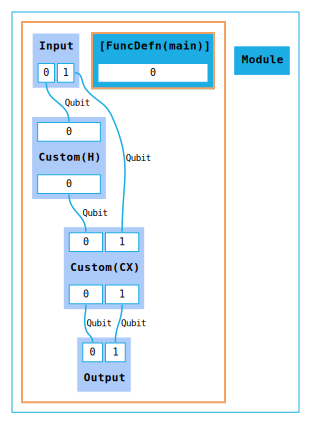

In [4]:
from tket.circuit.build import CircBuild, H, CX

builder = CircBuild.with_nqb(2)

builder.extend(H(0), CX(0, 1))
builder.set_tracked_outputs()
circ = builder.finish()
circ

### Using the Dataflow Builder

`CircBuild` can also be used to build arbitrary dataflow graphs. It lets you connect arbitrary inputs and outputs to each operation.
This way, you can define circuits that read the same boolean multiple times, or allocate qubits dynamically.

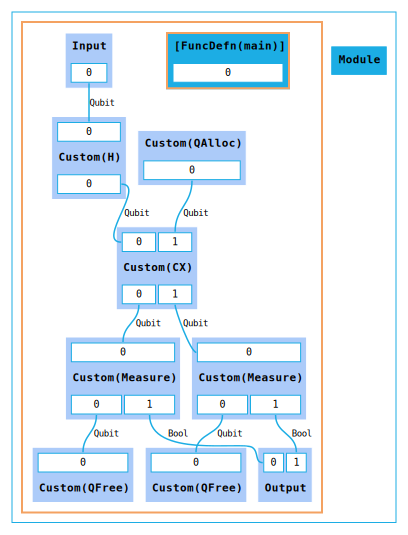

In [5]:
from tket.circuit.build import CircBuild, QAlloc, H, CX, Measure, QFree


# Start building DFG with one qubit input
builder = CircBuild.with_nqb(1)

# Qubits and booleans are identified by their "Wires" in the graph.
# We can get the wire for the single input qubit.
[q0] = builder.inputs()

# And allocate a new qubit, indexing the `Node` output gets the outgoing "Wire".
q1 = builder.add(QAlloc())[0]

# Each operation returns the new wires it creates.
q0 = builder.add(H(q0))[0]
q0, q1 = builder.add(CX(q0, q1))[0, 1]

# Some operations may have different numbers of inputs and outputs.
[q0, b0] = builder.add(Measure(q0))[0, 1]
[q1, b1] = builder.add(Measure(q1))[0, 1]

# And some may have no outputs at all.
builder.add(QFree(q0))
builder.add(QFree(q1))

# To get the final circuit, we need to set the outputs then call finish().
builder.set_outputs(b0, b1)
circ = builder.finish()

circ

### Using pytket

We can convert from and to `pytket` circuits.

In [6]:
from pytket.circuit import Circuit as PytketCircuit
from pytket.circuit.display import render_circuit_jupyter

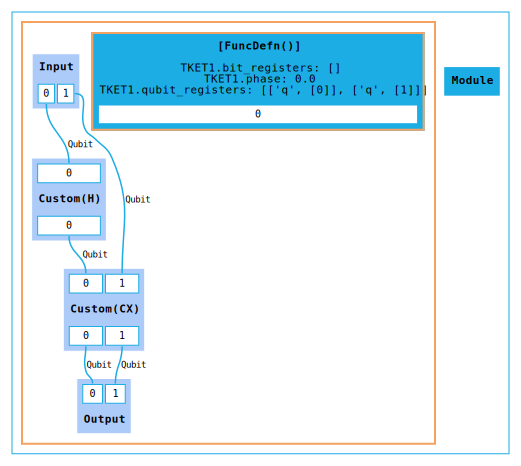

In [7]:
tk1_circ = PytketCircuit(2).H(0).CX(0, 1)
render_circuit_jupyter(tk1_circ)

circ = Tk2Circuit(tk1_circ)
circ

### Using guppy

Finally, if you have a circuit defined in `guppy` it can be imported directly into a `Tk2Circuit` object.

In [8]:
# We define a utility function to convert a GuppyModule to a Tk2Circuit.
# This will be included with guppy in the future.
from utils import guppy_to_circuit # type: ignore

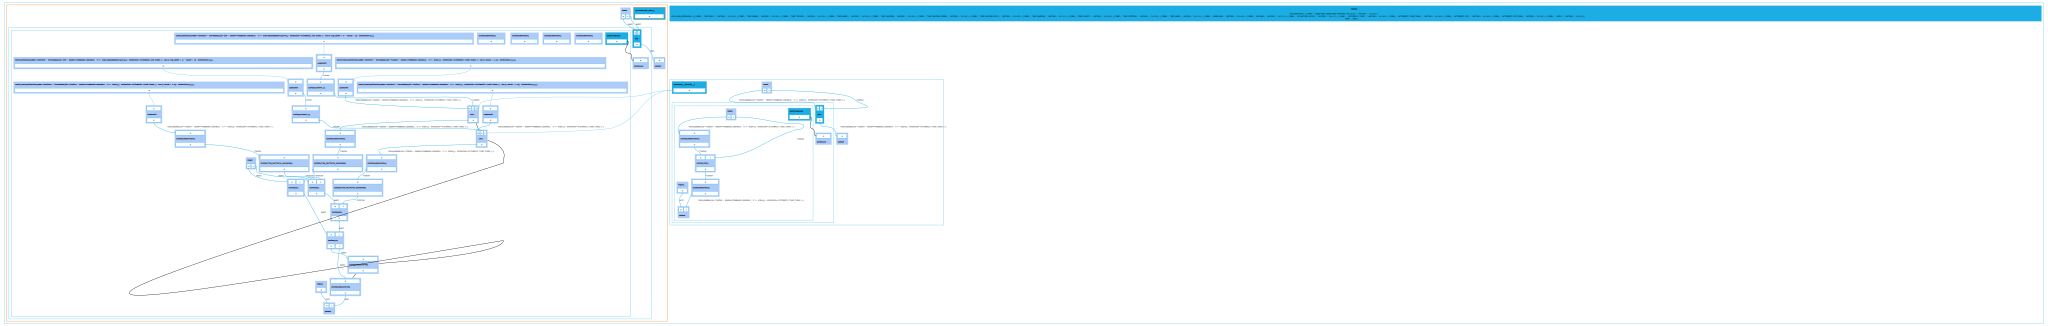

In [9]:
# Define a guppy module with a quantum function
from guppylang.std.angles import pi
from guppylang import guppy
from guppylang.std.builtins import owned
from guppylang.std.quantum import measure, qubit, rz, rx, cx, qubit

@guppy
def my_func(q0: qubit @owned, q1: qubit @owned) -> bool:
    rx(q0, pi / 2)
    rz(q1, pi)
    rz(q1, pi / 4)
    cx(q0, q1)
    _ = measure(q0)
    return measure(q1)

hugr = my_func.compile_function()
circ = guppy_to_circuit(my_func)
circ


As you can see, the HUGR produced by guppy looks quite scary!

Some simple cases of HUGRs can be converted back into pytket-style circuits. In cases that are too complex, tket2 will introduce opaque barriers to represent the missing operations. In this case, the result is rather underwhelming... and will improve soon!

In [10]:
circ.to_tket1()

[[UNSUPPORTED_HUGR] Barrier c[0]; ]